In [2]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 12.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [7]:
print(device)

cuda


In [8]:
# HyperParameter
batch_size = 50 # 모델 가중치 업데이트시 샘플 개수
epoch_num = 15
learning_rate = 0.0001 # 가중치 업데이트 정도

In [12]:
# MNIST 데이터 불러오기
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

In [13]:
print(len(train_data))
print(len(test_data))

60000
10000


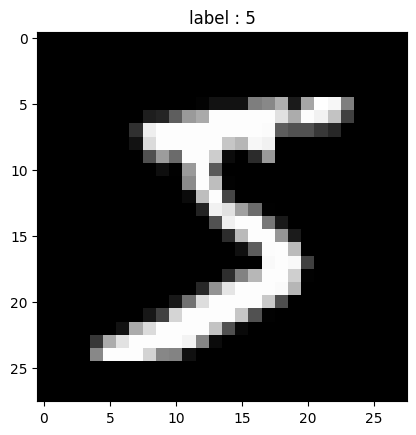

In [18]:
image, label = train_data[0]

# image -> [1, 28, 28] 3차원 텐서
# squeeze() -> 크기가 1인 차원을 없애는 함수로 2차원인 [28, 28]으로 만들어줌

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

In [19]:
# 미니 배치 구성

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

In [20]:
# CNN 구조 설계

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [22]:
# Optimizer, 손실 함수 정의

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류 문제이기 때문에

In [23]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# 모델 학습

model.train()

i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

/home/elicer/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0	Loss: 2.305
Train Step: 1000	Loss: 0.382
Train Step: 2000	Loss: 0.155
Train Step: 3000	Loss: 0.169
Train Step: 4000	Loss: 0.022
Train Step: 5000	Loss: 0.253
Train Step: 6000	Loss: 0.131
Train Step: 7000	Loss: 0.014
Train Step: 8000	Loss: 0.013
Train Step: 9000	Loss: 0.006
Train Step: 10000	Loss: 0.009
Train Step: 11000	Loss: 0.075
Train Step: 12000	Loss: 0.053
Train Step: 13000	Loss: 0.037
Train Step: 14000	Loss: 0.092
Train Step: 15000	Loss: 0.006
Train Step: 16000	Loss: 0.079
Train Step: 17000	Loss: 0.038


In [ ]:
# 모델 평가
model.eval()

correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1